# Project: Wrangling WeRateDogs Twitter Data


## Data Gathering
We will use data from WeRateDogs Twitter account.
The data will be gathered from three places
1. A csv file from their archive
2. An image prediction model
3. Tweets from the Twitter API that correspond to the ids in the archive file

#### Import Libraries

In [361]:
import json
import requests
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import wordcloud
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import tweepy
from timeit import default_timer as timer


#### Read the archive file the local storage

In [758]:
# Assign the archive data to a dataframe
archive = pd.read_csv('twitter-archive-enhanced.csv')

In [759]:
# Display the columns/features of the dataframe
archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

**archive table feature description**

* **tweet_id**: The unique identifier of the tweet
* **in_reply_to_status_id**: The identifier for a reply to a status
* **in_reply_to_user_id**: The identifier for reply to a user
* **timestamp**: The date and time the tweet was made
* **source**: The device the tweet was posted from
* **text**: The text of the tweet which includes the dog name and dog stage
* **retweeted_status_id**: The identifier of a retweet to a status
* **retweeted_status_user_id**: The identifier of a retweet to a user
* **retweeted_status_timestamp**: The date and time of the retweet
* **expanded_urls**: The link to the tweet (they have the tweet_id at the end)
* **rating_numerator**: The rating given to the dog
* **rating_denominator**: The denominator used for the rating the dogs
* **name**: The name of the dog
* **doggo**: A big pupper, usually older (according to the Dogtionary)
* **floofer**: Any dog really (according to the Dogtionary)
* **pupper**: A small doggo, usually younger (according to the Dogtionary)
* **puppo**: A transistional phase between pupper and doggo (according to the Dogtionary)

#### Use the Requests library to download the image prediction file

In [760]:
def read_from_url(url, folder_name):
    """A function that creates a folder on disk then downloads 
    data from the internet using the requests library and writes it to a file it creates 
    by splitting the url at the '/' symbol to create a list of elements in the url string
    and grabs the last element in the list to use as the file name. 
    a creates"""
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        try:
            response = requests.get(url)
            with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as url_file:
                url_file.write(response.content)
        except requests.exceptions.RequestException as e:
            raise SystemExit(e)
# save file
read_from_url('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv', 'dog_ratings_twitter')

In [761]:
# Confirm folder and file creation
directory = os.getcwd()
lst = os.walk(directory)
subdirs = [i for i in lst]
subdirs[2]


('C:\\Users\\Carla\\Workspace\\Udacity\\ALX\\projects\\project_2\\dog_ratings_twitter',
 [],
 ['image-predictions.tsv'])

In [762]:
# Read the file with pandas
predictions = pd.read_csv('dog_ratings_twitter/image-predictions.tsv', sep='\t')

In [763]:
predictions.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

**Image predictions table feature description**

* **tweet_id**: The unique identifier of the tweet
* **jpg_url**: The url to the dog's image
* **img_num**: The number of images used for the prediction
* **p1**: The algorithm's #1 prediction for the image in the tweet
* **p1_conf**: How confident the algorithm is in its #1 prediction
* **p1_dog**: Whether or not the #1 prediction is a breed of dog
* **p2**: The algorithm's second most likely prediction
* **p2_conf**: How confident the algorithm is in its #2 prediction
* **p2_dog** Whether or not the #2 prediction is a breed of dog
* **p3**: The algorithm's second most likely prediction
* **p3_conf**: How confident the algorithm is in its #2 prediction
* **p3_dog** Whether or not the #2 prediction is a breed of dog

#### Use the Tweepy library to query data via the Twitter API and save it into (tweet_json.txt)

In [93]:
class Tweepy:
    '''
    A class that takes in four api tokens from the Twitter API.
    Defines a class method that uses the tweepy library to
    create a tweepy.OAuthHandler object by passing
    in the consumer key and secret declared in the class.
    Use the created object to set the access tokens.
    Call the tweepy.API function by passing in the authenticated object
    and setting the wait_on_rate_limit and wait_on_rate_limit_notify to True
    in order to wait the limit of 15 minutes is reached and to notify when waiting on rate limit.
    Return an authenticated tweepy.api.API object used to retrieve data.
    '''
    consumer_key = os.environ.get('CONSUMER_KEY')
    consumer_secret = os.environ.get('CONSUMER_SECRET')
    access_token = os.environ.get('ACCESS_TOKEN')
    access_secret = os.environ.get('ACCESS_SECRET')

    def authenticate(self):
        auth = tweepy.OAuthHandler(self.consumer_key, self.consumer_secret)
        auth.set_access_token(self.access_token, self.access_secret)
        api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        return api

In [515]:
def get_tweets():
    tweet_ids = archive.tweet_id.values
    api = Tweepy().authenticate()
    count = 0
    fails_dict = {}
    start = timer()
    
    with open('tweet_json.txt', 'w') as dump_file:
        for tweet_id in tweet_ids:
            count +=1
            print(str(count) + '+'+ str(tweet_id))
            
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print('Success')
                json.dump(tweet._json, dump_file)
                dump_file.write('\n')
            except tweepy.TweepError as err:
                print('failed')
                fails_dict[tweet_id] = err
                pass
            
    end = timer()
    print(end - start)
    print(len(fails_dict))
    print(fails_dict)
get_tweets()

1+892420643555336193
Success
2+892177421306343426
Success
3+891815181378084864
Success
4+891689557279858688
Success
5+891327558926688256
Success
6+891087950875897856
Success
7+890971913173991426
Success
8+890729181411237888
Success
9+890609185150312448
Success
10+890240255349198849
Success
11+890006608113172480
Success
12+889880896479866881
Success
13+889665388333682689
Success
14+889638837579907072
Success
15+889531135344209921
Success
16+889278841981685760
Success
17+888917238123831296
Success
18+888804989199671297
Success
19+888554962724278272
Success
20+888202515573088257
failed
21+888078434458587136
Success
22+887705289381826560
Success
23+887517139158093824
Success
24+887473957103951883
Success
25+887343217045368832
Success
26+887101392804085760
Success
27+886983233522544640
Success
28+886736880519319552
Success
29+886680336477933568
Success
30+886366144734445568
Success
31+886267009285017600
Success
32+886258384151887873
Success
33+886054160059072513
Success
34+88598480001994752

Success
270+841320156043304961
Success
271+841314665196081154
Success
272+841077006473256960
Success
273+840761248237133825
Success
274+840728873075638272
Success
275+840698636975636481
Success
276+840696689258311684
Success
277+840632337062862849
Success
278+840370681858686976
Success
279+840268004936019968
Success
280+839990271299457024
Success
281+839549326359670784
Success
282+839290600511926273
Success
283+839239871831150596
Success
284+838952994649550848
Success
285+838921590096166913
Success
286+838916489579200512
Success
287+838831947270979586
Success
288+838561493054533637
Success
289+838476387338051585
Success
290+838201503651401729
Success
291+838150277551247360
Success
292+838085839343206401
Success
293+838083903487373313
Success
294+837820167694528512
Success
295+837482249356513284
Success
296+837471256429613056
Success
297+837366284874571778
failed
298+837110210464448512
Success
299+837012587749474308
failed
300+836989968035819520
Success
301+836753516572119041
Success
30

Success
535+807106840509214720
Success
536+807059379405148160
Success
537+807010152071229440
Success
538+806629075125202948
Success
539+806620845233815552
Success
540+806576416489959424
Success
541+806542213899489280
Success
542+806242860592926720
Success
543+806219024703037440
Success
544+805958939288408065
Success
545+805932879469572096
Success
546+805826884734976000
Success
547+805823200554876929
Success
548+805520635690676224
Success
549+805487436403003392
Success
550+805207613751304193
Success
551+804738756058218496
Success
552+804475857670639616
Success
553+804413760345620481
Success
554+804026241225523202
Success
555+803773340896923648
Success
556+803692223237865472
Success
557+803638050916102144
Success
558+803380650405482500
Success
559+803321560782307329
Success
560+803276597545603072
Success
561+802952499103731712
Success
562+802624713319034886
Success
563+802600418706604034
Success
564+802572683846291456
Success
565+802323869084381190
Success
566+802265048156610565
Success


Success
800+772826264096874500
Success
801+772615324260794368
Success
802+772581559778025472
Success
803+772193107915964416
Success
804+772152991789019136
Success
805+772117678702071809
Success
806+772114945936949249
Success
807+772102971039580160
Success
808+771908950375665664
Success
809+771770456517009408
Success
810+771500966810099713
Success
811+771380798096281600
Success
812+771171053431250945
Success
813+771136648247640064
Success
814+771102124360998913
Success
815+771014301343748096
Success
816+771004394259247104
failed
817+770787852854652928
Success
818+770772759874076672
Success
819+770743923962707968
failed
820+770655142660169732
Success
821+770414278348247044
Success
822+770293558247038976
Success
823+770093767776997377
Success
824+770069151037685760
Success
825+769940425801170949
Success
826+769695466921623552
Success
827+769335591808995329
Success
828+769212283578875904
Success
829+768970937022709760
Success
830+768909767477751808
Success
831+768855141948723200
Success
83

Success
1063+741099773336379392
Success
1064+741067306818797568
Success
1065+740995100998766593
Success
1066+740711788199743490
Success
1067+740699697422163968
Success
1068+740676976021798912
Success
1069+740373189193256964
Success
1070+740365076218183684
Success
1071+740359016048689152
Success
1072+740214038584557568
Success
1073+739979191639244800
Success
1074+739932936087216128
Success
1075+739844404073074688
Success
1076+739623569819336705
Success
1077+739606147276148736
Success
1078+739544079319588864
Success
1079+739485634323156992
Success
1080+739238157791694849
Success
1081+738891149612572673
Success
1082+738885046782832640
Success
1083+738883359779196928
Success
1084+738537504001953792
Success
1085+738402415918125056
Success
1086+738184450748633089
Success
1087+738166403467907072
Success
1088+738156290900254721
Success
1089+737826014890496000
Success
1090+737800304142471168
Success
1091+737678689543020544
Success
1092+737445876994609152
Success
1093+737322739594330112
Success


Success
1320+706516534877929472
Success
1321+706346369204748288
Success
1322+706310011488698368
Success
1323+706291001778950144
Success
1324+706265994973601792
Success
1325+706169069255446529
Success
1326+706166467411222528
Success
1327+706153300320784384
Success
1328+705975130514706432
Success
1329+705970349788291072
Success
1330+705898680587526145
Success
1331+705786532653883392
Success
1332+705591895322394625
Success
1333+705475953783398401
Success
1334+705442520700944385
Success
1335+705428427625635840
Success
1336+705239209544720384
Success
1337+705223444686888960
Success
1338+705102439679201280
Success
1339+705066031337840642
Success
1340+704871453724954624
Success
1341+704859558691414016
Success
1342+704847917308362754
Success
1343+704819833553219584
Success
1344+704761120771465216
Success
1345+704499785726889984
Success
1346+704491224099647488
Success
1347+704480331685040129
Success
1348+704364645503647744
Success
1349+704347321748819968
Success
1350+704134088924532736
Success


Success
1577+687460506001633280
Success
1578+687399393394311168
Success
1579+687317306314240000
Success
1580+687312378585812992
Success
1581+687127927494963200
Success
1582+687124485711986689
Success
1583+687109925361856513
Success
1584+687102708889812993
Success
1585+687096057537363968
Success
1586+686947101016735744
Success
1587+686760001961103360
Success
1588+686749460672679938
Success
1589+686730991906516992
Success
1590+686683045143953408
Success
1591+686618349602762752
Success
1592+686606069955735556
Success
1593+686394059078897668
Success
1594+686386521809772549
Success
1595+686377065986265092
Success
1596+686358356425093120
Success
1597+686286779679375361
Success
1598+686050296934563840
Success
1599+686035780142297088
Success
1600+686034024800862208
Success
1601+686007916130873345
Success
1602+686003207160610816
Success
1603+685973236358713344
Success
1604+685943807276412928
Success
1605+685906723014619143
Success
1606+685681090388975616
Success
1607+685667379192414208
Success


Success
1834+676146341966438401
Success
1835+676121918416756736
Success
1836+676101918813499392
Success
1837+676098748976615425
Success
1838+676089483918516224
Success
1839+675898130735476737
Success
1840+675891555769696257
Success
1841+675888385639251968
Success
1842+675878199931371520
Success
1843+675870721063669760
Success
1844+675853064436391936
Success
1845+675849018447167488
Success
1846+675845657354215424
Success
1847+675822767435051008
Success
1848+675820929667219457
Success
1849+675798442703122432
Success
1850+675781562965868544
Success
1851+675740360753160193
Success
1852+675710890956750848
Success
1853+675707330206547968
Success
1854+675706639471788032
Success
1855+675534494439489536
Success
1856+675531475945709568
Success
1857+675522403582218240
Success
1858+675517828909424640
Success
1859+675501075957489664
Success
1860+675497103322386432
Success
1861+675489971617296384
Success
1862+675483430902214656
Success
1863+675432746517426176
Success
1864+675372240448454658
Success


Success
2091+670786190031921152
Success
2092+670783437142401025
Success
2093+670782429121134593
Success
2094+670780561024270336
Success
2095+670778058496974848
Success
2096+670764103623966721
Success
2097+670755717859713024
Success
2098+670733412878163972
Success
2099+670727704916926465
Success
2100+670717338665226240
Success
2101+670704688707301377
Success
2102+670691627984359425
Success
2103+670679630144274432
Success
2104+670676092097810432
Success
2105+670668383499735048
Success
2106+670474236058800128
Success
2107+670468609693655041
Success
2108+670465786746662913
Success
2109+670452855871037440
Success
2110+670449342516494336
Success
2111+670444955656130560
Success
2112+670442337873600512
Success
2113+670435821946826752
Success
2114+670434127938719744
Success
2115+670433248821026816
Success
2116+670428280563085312
Success
2117+670427002554466305
Success
2118+670421925039075328
Success
2119+670420569653809152
Success
2120+670417414769758208
Success
2121+670411370698022913
Success


Success
2348+666057090499244032
Success
2349+666055525042405380
Success
2350+666051853826850816
Success
2351+666050758794694657
Success
2352+666049248165822465
Success
2353+666044226329800704
Success
2354+666033412701032449
Success
2355+666029285002620928
Success
2356+666020888022790149
Success
3441.503153699996
31
{888202515573088257: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 873697596434513921: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 872668790621863937: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 872261713294495745: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 869988702071779329: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 866816280283807744: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 861769973181624320: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 856602993587888130: TweepError(

##### Extract some columns from tweets_json.txt into a pandas dataframe

In [764]:
# Read all data retrieved using pd.read_json
tweets_full = pd.read_json('tweet_json.txt', lines=True)
## View all columns to choose from
tweets_full.columns

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive',
       'possibly_sensitive_appealable', 'lang', 'retweeted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'quoted_status'],
      dtype='object')

In [765]:
def json_to_df():
    tweet_list = []

    try:
        with open('tweet_json.txt', encoding='utf-8') as f:
            dicts_lst = [json.loads(line) for line in f]

            for dict_item in dicts_lst:
                tweet_list.append({'tweet_id': dict_item['id'],
                                   'lang': dict_item['lang'],
                                   'retweet_count': int(dict_item['retweet_count']),
                                   'favorite_count' : int(dict_item['favorite_count'])})
    except json.JSONDecodeError as error:
        raise error
    tweet_df = pd.DataFrame(tweet_list)
    return  tweet_df
api_tweets = json_to_df()

In [766]:
api_tweets.columns

Index(['tweet_id', 'lang', 'retweet_count', 'favorite_count'], dtype='object')

**api tweets table**

* **tweet_id**: The unique identifier of the tweet
* **timestamp**: The date the tweet was posted
* **lang**: The language used in the tweet
* **retweet_count**: If it's been retweeted, how many retweets?
* **favorite_count**: How many likes does the tweet have?
* **full_text**: The untruncated text of the tweet

## Assessing Data

In [408]:
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [252]:
archive.query('tweet_id == 666049248165822465')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None


In [225]:
# archive[archive.text.str.contains('RT @')]
archive[~archive.retweeted_status_id.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [250]:
archive.expanded_urls.duplicated().sum()

137

In [411]:
archive.expanded_urls.value_counts()

https://twitter.com/dog_rates/status/667152164079423490/photo/1                                                                                                                                                                                                    2
https://twitter.com/dog_rates/status/718631497683582976/photo/1                                                                                                                                                                                                    2
https://twitter.com/dog_rates/status/783839966405230592/photo/1,https://twitter.com/dog_rates/status/783839966405230592/photo/1,https://twitter.com/dog_rates/status/783839966405230592/photo/1                                                                    2
https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_r

In [28]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [30]:
archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [412]:
archive.sample(40)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1597,686050296934563840,NaN,NaN,2016-01-10 05:01:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Flávio. He's a Macedonian Poppycock. 9...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/686050296...,11,10,Flávio,None,None,None,None
387,826598799820865537,8.265984e+17,4.196984e+09,2017-02-01 01:11:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I was going to do 007/10, but the joke wasn't ...",NaN,NaN,NaN,NaN,7,10,None,None,None,None,None
416,822610361945911296,NaN,NaN,2017-01-21 01:02:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please stop sending in non-canines like this V...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/822610361...,12,10,None,None,None,None,None
1249,711306686208872448,NaN,NaN,2016-03-19 21:41:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",What hooligan sent in pictures w/out a dog in ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/711306686...,3,10,None,None,None,None,None
2062,671163268581498880,NaN,NaN,2015-11-30 03:06:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Pack of horned dogs here. Very team-oriented b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671163268...,8,10,None,None,None,None,None
1657,683142553609318400,NaN,NaN,2016-01-02 04:27:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Brandy. She's a member of the Bloods. Men...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683142553...,9,10,Brandy,None,None,pupper,None
1121,730924654643314689,NaN,NaN,2016-05-13 00:56:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Pls stop sending non-canine...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/730924654...,9,10,unacceptable,None,None,None,None
976,750026558547456000,NaN,NaN,2016-07-04 18:00:41 +0000,"<a href=""https://about.twitter.com/products/tw...",Meet Jax &amp; Jil. Jil is yelling the pledge ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750026558...,10,10,Jax,None,None,None,None
1102,735274964362878976,NaN,NaN,2016-05-25 01:03:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please stop sending in your...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/735274964...,11,10,None,None,None,None,None
2272,667491009379606528,NaN,NaN,2015-11-19 23:53:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Two dogs in this one. Both are rare Jujitsu Py...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667491009...,7,10,None,None,None,None,None


In [1123]:
archive[archive.name.str.islower()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139...,14,10,such,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. This is quite clearly a smo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Guys, we only rate dogs. This is quite clearly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/855459453...,12,10,quite,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None


In [42]:
archive.rating_numerator.describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [52]:
archive[archive['rating_numerator'] == 1776]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None


In [43]:
archive.rating_denominator.describe()

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

In [91]:
archive.query('rating_denominator != 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


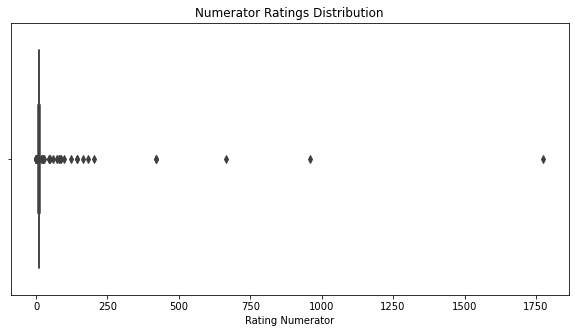

In [10]:
fig = plt.figure(figsize =(10, 5))
plt.title('Numerator Ratings Distribution')
ax = sns.boxplot(x='rating_numerator', data=archive)
ax.set_xlabel('Rating Numerator');

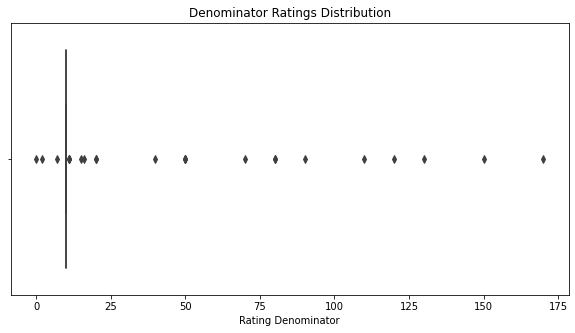

In [11]:
fig = plt.figure(figsize =(10, 5))
plt.title('Denominator Ratings Distribution')
ax = sns.boxplot(x='rating_denominator', data=archive)
ax.set_xlabel('Rating Denominator');

In [124]:
predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [125]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1517,787322443945877504,https://pbs.twimg.com/media/Cu0hlfwWYAEdnXO.jpg,1,seat_belt,0.747739,False,golden_retriever,0.105703,True,dingo,0.017257,False
505,675891555769696257,https://pbs.twimg.com/media/CWE_x33UwAEE3no.jpg,1,Italian_greyhound,0.305637,True,whippet,0.232057,True,Great_Dane,0.117806,True
1771,827653905312006145,https://pbs.twimg.com/media/C3xq1ZeWEAEuzw3.jpg,1,collie,0.285555,True,Border_collie,0.217306,True,Saint_Bernard,0.143245,True
362,672834301050937345,https://pbs.twimg.com/media/CVZjOktVAAAtigw.jpg,1,Pembroke,0.582560,True,Cardigan,0.258869,True,nipple,0.033835,False
731,686683045143953408,https://pbs.twimg.com/media/CYeWlh0WAAADhsj.jpg,1,Norwich_terrier,0.100499,True,cocker_spaniel,0.080671,True,golden_retriever,0.079406,True
1663,812372279581671427,https://pbs.twimg.com/media/C0YgO3DW8AAz98O.jpg,2,golden_retriever,0.784873,True,cocker_spaniel,0.087788,True,Labrador_retriever,0.083275,True
358,672614745925664768,https://pbs.twimg.com/media/CVWbitUW4AAzclx.jpg,1,starfish,0.712717,False,goldfish,0.258865,False,sea_cucumber,0.002015,False
732,686730991906516992,https://pbs.twimg.com/media/CYfCMdFWAAA44YA.jpg,1,Tibetan_mastiff,0.338812,True,Newfoundland,0.180925,True,golden_retriever,0.180023,True
214,670046952931721218,https://pbs.twimg.com/media/CUx8JSEXIAU6zPp.jpg,1,Blenheim_spaniel,0.998335,True,beagle,0.000647,True,Brittany_spaniel,0.000392,True
1714,818627210458333184,https://pbs.twimg.com/media/C1xZGkzWIAA8vh4.jpg,1,Labrador_retriever,0.384188,True,beagle,0.255917,True,grocery_store,0.079799,False


In [14]:
predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [20]:
predictions.duplicated().sum()

0

In [37]:
predictions.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [520]:
api_tweets

,tweet_id,lang,retweet_count,favorite_count
0,892420643555336193,en,7009,33807
1,892177421306343426,en,5301,29331
2,891815181378084864,en,3481,22051
3,891689557279858688,en,7225,36939
4,891327558926688256,en,7760,35311
...,...,...,...,...
2320,666049248165822465,en,37,89
2321,666044226329800704,en,115,247
2322,666033412701032449,en,36,100
2323,666029285002620928,en,39,112


In [519]:
api_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2325 non-null   int64 
 1   lang            2325 non-null   object
 2   retweet_count   2325 non-null   int64 
 3   favorite_count  2325 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 72.8+ KB


In [521]:
api_tweets.duplicated().sum()

0

In [522]:
api_tweets.isnull().sum()

tweet_id          0
lang              0
retweet_count     0
favorite_count    0
dtype: int64

In [523]:
api_tweets.sample(10)

,tweet_id,lang,retweet_count,favorite_count
1014,743835915802583040,en,1874,0
874,758467244762497024,en,2029,4476
1023,742528092657332225,en,1796,4112
1891,674262580978937856,en,386,1180
1304,705442520700944385,en,1465,4078
1593,684914660081053696,en,1326,3226
252,841833993020538882,en,13604,0
855,760521673607086080,en,1288,3925
2129,669571471778410496,en,883,1408
1227,710588934686908417,en,1701,4190


In [524]:
nums_api_tweets = api_tweets[['retweet_count', 'favorite_count']]

In [525]:
nums_api_tweets.describe()

,retweet_count,favorite_count
count,2325.000000,2325.000000
mean,2472.818065,7060.403011
std,4186.496432,10965.468225
min,1.000000,0.000000
25%,495.000000,1229.000000
50%,1151.000000,3051.000000
75%,2861.000000,8613.000000
max,70738.000000,144890.000000


In [526]:
all_columns = pd.Series(list(archive) + list(api_tweets))
all_columns[all_columns.duplicated()]

17    tweet_id
dtype: object

### Quality issues
#### archived tweets table


* [Object datatype for timestamp instead of datetime datatype](#Issue-#1)
example: tweet_id 700847567345688576
* [Some tweets are retweets](#Issue-#4)
* [Erroneous integer datatype for tweet_id](#Issue-#8)
* [Missing dog names misrepresented as None](#Issue-10)
* [Missing dog stages misrepresented as None](#Issue-#6-&-#7)
* [Non-logical names for dog in the name column, i.e quite, such, not](#Issue-#9)
* [Some rating_denominators are not equal to 10](#Issue-#12)

#### image predictions table
* [Inconsistent capitalization of names in p1, p2, and p3](#Issue-#11)
* [Erroneous integer datatype for tweet_id](#Issue-#8)

#### api tweets table
* [Erroneous datatype integer for tweet_id](#Issue-#8)

### Tidiness issues
* [Some of the expanded_urls rows in the archive table contain more than one url](#Issue-#3)
* [The in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp columns are not needed for this analysis](#Issue-#5)
* [The dog stages are spread across four columns; doggo, floofer, pupper, puppo](Issue-#6-&-#7)
* [There are tweets dated before 2017 i.e 2015, 2016. (the image prediction file only covers 2017)](#Issue-#2)

## Cleaning Data

In [767]:
# Make copies of original pieces of data
tweets_clean = api_tweets.copy()
archive_clean = archive.copy()
predictions_clean = predictions.copy()

In order to filter data that is only from 2017, I have to convert the timestamp column datatype to datetime first otherwise pandas does not recognize them as dates.

### Issue #1

**Object datatype for timestamp instead of datetime datatype in the archive**

#### Define

Use pd.to_datetime to convert column values to datetime

#### Code

In [768]:
archive_clean['timestamp'] = pd.to_datetime(archive_clean.timestamp)

#### Test

In [769]:
archive_clean.timestamp.dtypes

datetime64[ns, UTC]

### Issue #2

**There are tweets dated before 2017 i.e 2015, 2016. (the image prediction file only covers 2017)
example: tweet_id 700847567345688576**

#### Define

Filter and drop all tweets dated before 2017 in both archive and tweets table

#### Code

In [770]:
not_2017 = archive_clean[archive_clean.timestamp.dt.year != 2017]
archive_clean.drop(not_2017.index, inplace=True)

#### Test

In [771]:
archive_clean[archive_clean.timestamp.dt.year != 2017]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [772]:
archive_clean.query('tweet_id == 700847567345688576')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [773]:
archive_clean.shape

(483, 17)

### Issue #3

**Some of the expanded_urls rows in the archive table contain more than one url**

#### Define
* Ceate new urls by combining tweet status uris with corresponding tweet_ids and assign them to a new column: tweet_status_urls.
* Then drop the expanded_urls column from the table

#### Code

In [774]:
uri = 'https://twitter.com/dog_rates/status/'

In [775]:
archive_clean['tweet_status_urls'] = archive_clean['tweet_id'].apply(lambda  row: '{}{}/photo/1'.format(uri,row))

In [776]:
archive_clean.drop('expanded_urls', axis=1, inplace=True)

#### Test

In [777]:
archive_clean.shape

(483, 17)

In [257]:
archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'rating_numerator', 'rating_denominator',
       'name', 'doggo', 'floofer', 'pupper', 'puppo', 'tweet_status_urls'],
      dtype='object')

In [778]:
len(archive_clean.tweet_status_urls.unique())

483

### Issue #4
**Some tweets are retweets**

#### Define
Filter and delete all tweets that the retweet_status_id is not NaN(these tweets also contain 'RT @') in the archive dataframe.

#### Code

In [779]:
archive_clean= archive_clean[archive_clean.retweeted_status_id.isnull()]

#### Test

In [780]:
sum(~archive_clean.retweeted_status_id.isnull())

0

### Issue #5
* in_reply_to_status_id
* in_reply_to_user_id
* retweeted_status_id
* retweeted_status_user_id
* retweeted_status_timestamp

are columns not needed for this analysis. Additionally, they hava missing values of about 90%


#### Define
Drop these columns from the archive table

#### Code

In [781]:
out_of_scope = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_user_id', 'retweeted_status_id', 'retweeted_status_timestamp']
archive_clean.drop(out_of_scope, axis=1, inplace=True)

#### Test

In [782]:
archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'tweet_status_urls'],
      dtype='object')

### Issue #6 & #7
**The dog stages are spread across four columns; doggo, floofer, pupper, puppo instead just one**:*

**Missing dog stages in the archive table misrepresented as None**

#### Define
* Use Regex to findall on the text column to find dog stages and fill the stage column with those values.
* Replace missing values with np.nan (NaN)
* Drop the the four columns from the table.

#### Code

In [783]:
stages = ['doggo', 'floofer', 'pupper', 'puppo' ]

In [784]:
pattern = r"(?=(\b" + '|'.join(stages) + r"\b))"
archive_clean["stage"] = archive_clean.text.str.findall(pattern).str.join(',').replace({'':np.nan})

In [785]:
archive_clean.drop(stages, axis=1, inplace=True)

#### Test

In [786]:
archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'tweet_status_urls', 'stage'],
      dtype='object')

In [787]:
archive_clean.stage.value_counts()

doggo          31
pupper         22
puppo           9
floofer         1
puppo,doggo     1
Name: stage, dtype: int64

In [788]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399 entries, 0 to 482
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            399 non-null    int64              
 1   timestamp           399 non-null    datetime64[ns, UTC]
 2   source              399 non-null    object             
 3   text                399 non-null    object             
 4   rating_numerator    399 non-null    int64              
 5   rating_denominator  399 non-null    int64              
 6   name                399 non-null    object             
 7   tweet_status_urls   399 non-null    object             
 8   stage               64 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(3), object(5)
memory usage: 31.2+ KB


### Issue #8
**Erroneous tweet_id misrepresented as integer in all three tables**

#### Define
Convert tweet_id to string datatype

#### Code

In [789]:
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)
tweets_clean.tweet_id = tweets_clean.tweet_id.astype(str)
predictions_clean.tweet_id = predictions_clean.tweet_id.astype(str)

#### Test

In [790]:
archive_clean.tweet_id.dtype

dtype('O')

In [791]:
tweets_clean.tweet_id.dtype

dtype('O')

In [792]:
predictions_clean.tweet_id.dtype

dtype('O')

### Issue #9
**Non-logical names in the archive table i.e quite, such, a, not, one**

#### Define
Filter out non-logical names; they seem to all be lowercased.

#### Code

In [793]:
non_logical = []
_ = [non_logical.append(i) for i in archive_clean.name if i.islower()]

In [794]:
non_logical

['such', 'a', 'quite', 'quite', 'not', 'one']

In [795]:
archive_clean = archive_clean[~archive_clean.name.str.islower()]


#### Test

In [796]:
archive_clean

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,tweet_status_urls,stage
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,https://twitter.com/dog_rates/status/892420643...,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,https://twitter.com/dog_rates/status/892177421...,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,https://twitter.com/dog_rates/status/891815181...,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,https://twitter.com/dog_rates/status/891689557...,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,https://twitter.com/dog_rates/status/891327558...,NaN
...,...,...,...,...,...,...,...,...,...
477,815990720817401858,2017-01-02 18:38:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jack. He's one of the rare doggos that do...,11,10,Jack,https://twitter.com/dog_rates/status/815990720...,doggo
478,815966073409433600,2017-01-02 17:00:46+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a pupper with squeaky hiccups. Please e...,13,10,None,https://twitter.com/dog_rates/status/815966073...,pupper
480,815736392542261248,2017-01-02 01:48:06+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Akumi. It's his birthday. He received ...,11,10,Akumi,https://twitter.com/dog_rates/status/815736392...,NaN
481,815639385530101762,2017-01-01 19:22:38+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Titan. His nose is quite chilly. Reque...,12,10,Titan,https://twitter.com/dog_rates/status/815639385...,NaN


### Issue #10
**Missing dog names in the archive table misrepresented as None**

#### Define
Use np.nan to replace 'None' with NaN

#### Code

In [797]:
archive_clean.name = archive_clean.name.replace('None', np.nan)

#### Test

In [798]:
archive_clean

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,tweet_status_urls,stage
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,https://twitter.com/dog_rates/status/892420643...,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,https://twitter.com/dog_rates/status/892177421...,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,https://twitter.com/dog_rates/status/891815181...,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,https://twitter.com/dog_rates/status/891689557...,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,https://twitter.com/dog_rates/status/891327558...,NaN
...,...,...,...,...,...,...,...,...,...
477,815990720817401858,2017-01-02 18:38:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jack. He's one of the rare doggos that do...,11,10,Jack,https://twitter.com/dog_rates/status/815990720...,doggo
478,815966073409433600,2017-01-02 17:00:46+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a pupper with squeaky hiccups. Please e...,13,10,NaN,https://twitter.com/dog_rates/status/815966073...,pupper
480,815736392542261248,2017-01-02 01:48:06+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Akumi. It's his birthday. He received ...,11,10,Akumi,https://twitter.com/dog_rates/status/815736392...,NaN
481,815639385530101762,2017-01-01 19:22:38+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Titan. His nose is quite chilly. Reque...,12,10,Titan,https://twitter.com/dog_rates/status/815639385...,NaN


### Issue 11

**Inconsistent capitalization of names in p1, p2, and p3 in the predictions table**

#### Define
Use the capitalize function to capitalize every first letter in the columns

#### Code

In [799]:
breeds = ['p1', 'p2', 'p3']
predictions_clean[breeds] = predictions_clean[breeds].apply(lambda x: x.str.capitalize())

#### Test

In [800]:
predictions_clean

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,Collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Paper_towel,0.170278,False,Labrador_retriever,0.168086,True,Spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True


### Issue #12
**Rating denominator in the archives table is lower or higher than 10**

#### Define
Delete all tweets that with rating denominator that is not equal to 10

#### Code

In [801]:
archive_clean = archive_clean[archive_clean.rating_denominator == 10]


#### Test

In [803]:
archive_clean[archive_clean.rating_denominator !=10]

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,tweet_status_urls,stage


#### Test

In [804]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 482
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            390 non-null    object             
 1   timestamp           390 non-null    datetime64[ns, UTC]
 2   source              390 non-null    object             
 3   text                390 non-null    object             
 4   rating_numerator    390 non-null    int64              
 5   rating_denominator  390 non-null    int64              
 6   name                284 non-null    object             
 7   tweet_status_urls   390 non-null    object             
 8   stage               63 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(2), object(6)
memory usage: 30.5+ KB


In [805]:
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [807]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2325 non-null   object
 1   lang            2325 non-null   object
 2   retweet_count   2325 non-null   int64 
 3   favorite_count  2325 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 72.8+ KB


## Storing Data

I will merge and save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

###  Merge the three dataframes

In [808]:
 twitter_archive_master = archive_clean.merge(tweets_clean,on='tweet_id').merge(predictions_clean,on='tweet_id')

### Export the dataframe to a csv file using pd.to_csv()

In [809]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, I will analyze and visualize my wrangled data.

In [810]:
twitter_master = pd.read_csv('twitter_archive_master.csv')

In [811]:
twitter_master.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,tweet_status_urls,stage,lang,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
251,831650051525054464,2017-02-14 23:43:18+00:00,"<a href=""http://twitter.com/download/iphone"" r...","I usually only share these on Friday's, but th...",13,10,NaN,https://twitter.com/dog_rates/status/831650051...,NaN,en,...,1,Eskimo_dog,0.530416,True,Siberian_husky,0.180335,True,Norwegian_elkhound,0.104314,True
199,841680585030541313,2017-03-14 16:01:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Penny. She's a dragon slayer. Feared b...,12,10,Penny,https://twitter.com/dog_rates/status/841680585...,NaN,en,...,1,Chihuahua,0.547401,True,Bow_tie,0.198361,False,Pembroke,0.058492,True
280,826848821049180160,2017-02-01 17:44:55+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cupid. He was found in the trash. Now ...,13,10,Cupid,https://twitter.com/dog_rates/status/826848821...,doggo,en,...,4,Great_pyrenees,0.858764,True,Golden_retriever,0.023526,True,Pekinese,0.017104,True
5,891087950875897856,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,13,10,NaN,https://twitter.com/dog_rates/status/891087950...,NaN,en,...,1,Chesapeake_bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
265,828770345708580865,2017-02-07 01:00:22+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Alfie. He's your Lyft for tonight. Kin...,13,10,Alfie,https://twitter.com/dog_rates/status/828770345...,NaN,en,...,1,Seat_belt,0.765979,False,Chesapeake_bay_retriever,0.033899,True,Polecat,0.027252,False


### Insights:

**note:
* doggo: A big pupper, usually older
* puppo:  A transistional phase between pupper and doggo
* pupper:  A small doggo, usually younger
* floofer:  Any dog really

1. **What is the relationship between retweet_counts and favorite_count if any?**

* There's a strong positive linear correlation between the retweet count and the favorite count. It shows that the dogs that got retweeted more also got favorited more, which makes sense when you think about how content goes viral online these days. See [Figure 1](#Figure-1)

2. What stages of dogs have the most retweets?

* The combination of doggo and puppo seems to have the most retweets overall. Although, looking at them individually you see that the puppo stage has more retweets on its own compared to the doggo stage. The floofer has the least retweets in the group. Even if you add pupper numbers to puppo still it seems that doggo and puppo together make for many retweets! Go #dogpup. See [Figure 2](#Figure-2)

3. What stages of dogs have been favorited the most?

* The combination of doggo and puppp again seems to have the most favorite overall. The same case as with the retweets, individually the puppo stage has more retweets on its own compared to the doggo stage. This time the doggo stage has the least numbers in the group. See [Figure 3](#Figure-3)

4. What is the most frequent dog stage?

* The most frequent dog stage is the doggo. It appears 28 times followed by the pupper that has 21. It is worth noting that the puppo/doggo and the floofer stages each have only one occurence. By this analysis: See [Figure 4](#Figure-4)
    * Most dogs in the dataset are in the doggo stage
    * Most retweeted and favorited stages not in the doggo stage
    * Doggo/puppo stage has the least frequency in the dataset
    * Doggo/puppo stage is the most retweeted and favorited
 5. How many images were used to match each stage for  [P1?](#Figure-6)
 6. How many images were used to match each stage for [P2?](#Figure-7)
 7. How many images were used to match each stage for [P3?](#Figure-8)
 8. Number of True or False Predictions for Each [Prediction Level](#Figure-5)
 * The image prediction had True results more than False results. There are some results that are not accurate as they are not valid dog breeds.

### Visualization

#### Figure 1

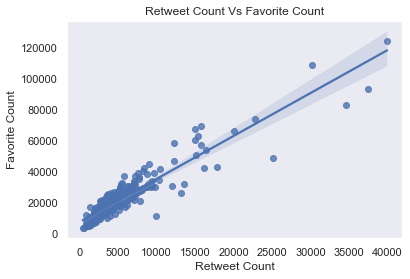

In [812]:
# plt.scatter(twitter_archive_master.retweet_count, twitter_archive_master.favorite_count)
sns.regplot(data = twitter_master, x = "retweet_count", y = "favorite_count")
sns.set(style = "dark")
plt.title('Retweet Count Vs Favorite Count')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count')
plt.savefig('figure1.png', dpi=100);

#### Figure 2

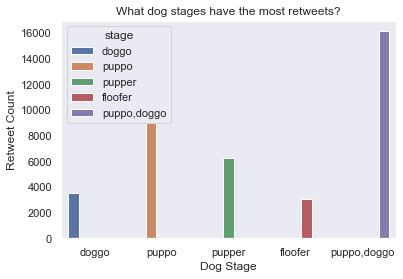

In [813]:
sns.barplot(x = 'stage', y = 'retweet_count', hue = 'stage', data = twitter_master, ci=None)
plt.title('What dog stages have the most retweets?')
plt.xlabel('Dog Stage')
plt.ylabel('Retweet Count')
plt.savefig('figure2.png', dpi=150);

In [814]:
twitter_master.groupby('stage')['retweet_count'].mean()

stage
doggo           3491.892857
floofer         3080.000000
pupper          6284.700000
puppo           8982.666667
puppo,doggo    16141.000000
Name: retweet_count, dtype: float64

In [815]:
# Sum Puppo and Pupper retweets
6284.700000 + 8982.666667

15267.366666999998

#### Figure 3

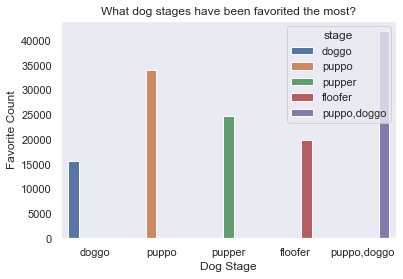

In [816]:
sns.barplot(x = 'stage', y = 'favorite_count', hue = 'stage', data = twitter_master, ci=None)
plt.title('What dog stages have been favorited the most?')
plt.xlabel('Dog Stage')
plt.ylabel('Favorite Count')
plt.savefig('figure3.png', dpi=150);

#### Figure 4

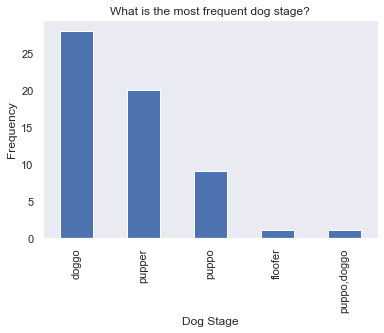

In [817]:
twitter_master.stage.value_counts().plot(kind='bar')
plt.title('What is the most frequent dog stage?')
plt.xlabel('Dog Stage')
plt.ylabel('Frequency')
plt.savefig('figure4.png', dpi=100);

In [818]:
twitter_master.stage.value_counts()

doggo          28
pupper         20
puppo           9
floofer         1
puppo,doggo     1
Name: stage, dtype: int64

#### Figure 5

In [279]:
value_list = ['True', 'False']

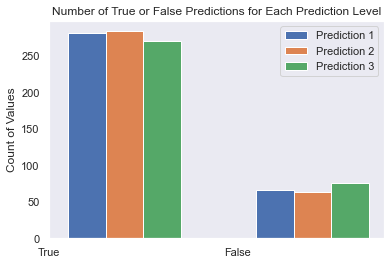

In [819]:
x = np.arange(len(value_list))
plt.bar(x +0.20, twitter_master.p1_dog.value_counts(),  width=0.2, label='Prediction 1')
plt.bar(x +0.20*2, twitter_master.p2_dog.value_counts(), width=0.2, label='Prediction 2')
plt.bar(x +0.20*3, twitter_master.p3_dog.value_counts(), width=0.2, label='Prediction 3')
plt.xticks(x, value_list)
plt.title('Number of True or False Predictions for Each Prediction Level')
plt.ylabel('Count of Values')
plt.legend()
plt.savefig('figure5.png', dpi=150);


#### Figure 6

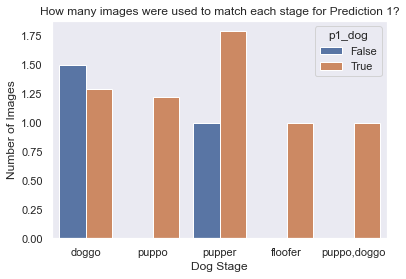

In [820]:
lst = ['p1_dog', 'p2_dog', 'p3_dog']
sns.barplot(x = 'stage',
            y = 'img_num',
            hue = 'p1_dog',
            data = twitter_master, ci = None,)
plt.title('How many images were used to match each stage for Prediction 1?')
plt.ylabel('Number of Images')
plt.xlabel('Dog Stage')
plt.savefig('figure6.png', dpi=150);

#### Figure 7

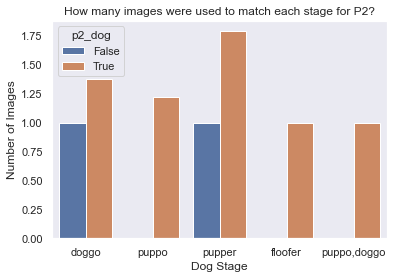

In [821]:
sns.barplot(x = 'stage',
            y = 'img_num',
            hue = 'p2_dog',
            data = twitter_master, ci = None)
plt.title('How many images were used to match each stage for P2?')
plt.ylabel('Number of Images')
plt.xlabel('Dog Stage')
plt.savefig('figure7.png', dpi=150);

#### Figure 8

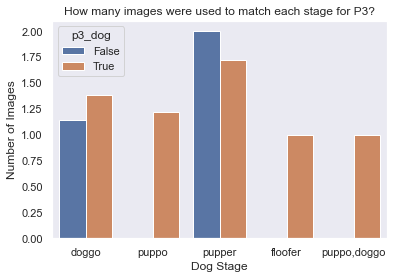

In [822]:
sns.barplot(x = 'stage',
            y = 'img_num',
            hue = 'p3_dog',
            data = twitter_master, ci = None,)
plt.title('How many images were used to match each stage for P3?')
plt.ylabel('Number of Images')
plt.xlabel('Dog Stage')
plt.savefig('figure8.png', dpi=150);

In [687]:
word_cloud_copy = twitter_master.copy()


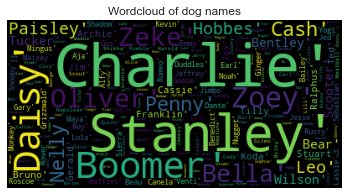

In [756]:
filter_p1 = word_cloud_copy['p1_dog']==True
dog_name_p1 = (word_cloud_copy['name'].where(filter_p1))
dog_name_p1.dropna(inplace=True)
name_p1= dog_name_p1.values
cloud = wordcloud.WordCloud().generate(str(name_p1))
plt.imshow(cloud)
plt.title('Wordcloud of dog names')
plt.axis("off")
plt.show();

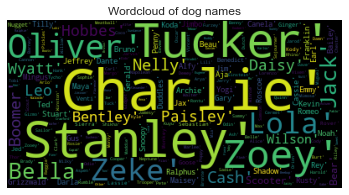

In [753]:
filter_p2 = word_cloud_copy['p2_dog']==True
dog_name_p2 = (word_cloud_copy['name'].where(filter_p2))
dog_name_p2.dropna(inplace=True)
name_p2 = dog_name_p2.values
cloud = wordcloud.WordCloud().generate(str(name_p2))
plt.imshow(cloud)
plt.title('Wordcloud of dog names')
plt.axis("off")
plt.show();


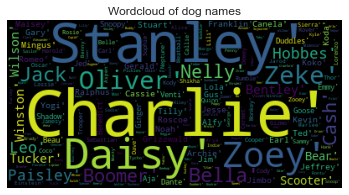

In [754]:
filter_p3 = word_cloud_copy['p3_dog']==True
dog_name_p3 = (word_cloud_copy['name'].where(filter_p3))
dog_name_p3.dropna(inplace=True)
name_p3 = dog_name_p3.values
cloud = wordcloud.WordCloud().generate(str(name_p3))
plt.imshow(cloud)
plt.axis("off")
plt.title('Wordcloud of dog names')
plt.savefig('figure9.png', dpi=150);
plt.show();

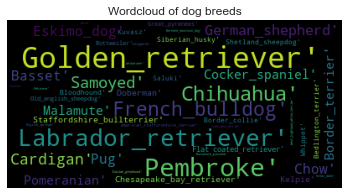

In [755]:
breeds_p1 = (word_cloud_copy['p1'].where(filter_p1))
breeds_p1.dropna(inplace=True)
breed_1 = breeds_p1.values
cloud = wordcloud.WordCloud().generate(str(breed_1))
plt.imshow(cloud)
plt.axis("off")
plt.title('Wordcloud of dog breeds')
plt.savefig('figure10.png', dpi=150);
plt.show();

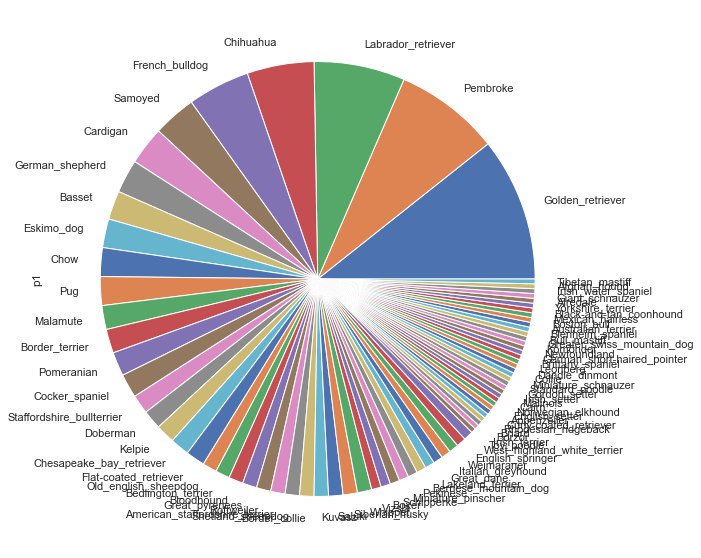

In [658]:
breeds_p1.value_counts().plot(kind='pie', figsize=(20,10));

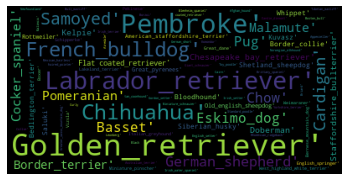

In [665]:
breeds_p2 = (word_cloud_copy['p2'].where(filter_p2))
breeds_p2.dropna(inplace=True)
breed_2 = breeds_p1.values
cloud2 = wordcloud.WordCloud().generate(str(breed_2))
plt.imshow(cloud2)
plt.axis("off")
plt.show()

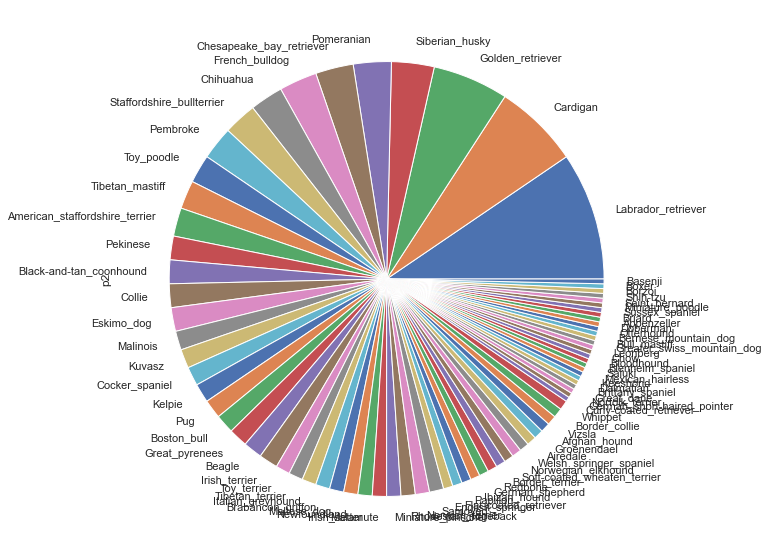

In [669]:
breeds_p2.value_counts().plot(kind='pie', figsize=(20,10));

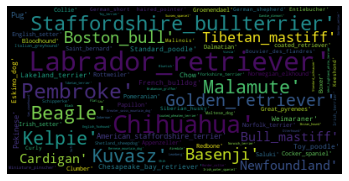

In [675]:
breeds_p3 = (word_cloud_copy['p3'].where(filter_p3))
breeds_p3.dropna(inplace=True)
breed_3 = breeds_p3.values
cloud2 = wordcloud.WordCloud().generate(str(breed_3))
plt.imshow(cloud2)
plt.axis("off")
plt.show();